<a href="https://colab.research.google.com/github/GianRomani/Neural_search_engine/blob/main/DM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try: 
  #this will raise an error if you are not using Colab
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print("You are not using Colab")

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/Data Mining/Project/archive.zip"

In [ ]:
#!unzip "/content/drive/MyDrive/Data Mining/Project/archive.zip" -d "/content/drive/MyDrive/Data Mining/Project/"

# EDA

It can be interesting and helpful to analyze:

*   the distribution of the scores among the questions,
*   number of answers for question (and scores of those answers);
*   creation dates for the posts;
*   if a post was closed (and why);
*   popular users (who answered a lot of questions)





In [3]:
import pandas as pd

<h2>Questions</h2>

*   Id: id of the question;
*   OwnerUserId: id of the account who post the question;
*   CreationDate: when the question was posted;
*   ClosedDate: when the question was closed;
*   Score: upvotes - downvotes;
*   Title: title of the question;
*   Body: the question

In [4]:
questions = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Questions.csv",encoding="ISO-8859-1") #utf-8 is not good in this case

In [ ]:
questions.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...


In [ ]:
questions.describe()

,Id,OwnerUserId,Score
count,1.264216e+06,1.249762e+06,1.264216e+06
mean,2.132745e+07,2.155177e+06,1.781537e+00
std,1.151445e+07,1.801265e+06,1.366389e+01
min,8.000000e+01,1.000000e+00,-7.300000e+01
25%,1.142598e+07,6.589110e+05,0.000000e+00
50%,2.172542e+07,1.611830e+06,0.000000e+00
75%,3.154542e+07,3.353792e+06,1.000000e+00
max,4.014338e+07,7.046594e+06,5.190000e+03


In [ ]:
#What is the distribution of the scores among the questions?
score_distribution = questions["Score"].value_counts(bins=20)
score_distribution

(-78.26400000000001, 190.15]    1263601
(190.15, 453.3]                     478
(453.3, 716.45]                      78
(716.45, 979.6]                      30
(979.6, 1242.75]                     11
(1505.9, 1769.05]                     9
(1242.75, 1505.9]                     4
(2295.35, 2558.5]                     3
(3611.1, 3874.25]                     1
(4926.85, 5190.0]                     1
(2032.2, 2295.35]                     0
(2821.65, 3084.8]                     0
(3084.8, 3347.95]                     0
(3347.95, 3611.1]                     0
(1769.05, 2032.2]                     0
(3874.25, 4137.4]                     0
(4137.4, 4400.55]                     0
(4400.55, 4663.7]                     0
(4663.7, 4926.85]                     0
(2558.5, 2821.65]                     0
Name: Score, dtype: int64

In [ ]:
#negative scores
negative_scores_questions = questions[questions["Score"] < 0]
negative_scores_questions

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
487,43960,3262.0,2008-09-04T15:07:30Z,NaN,-1,COTS Workshop Registration System,<p>Does anyone have any experience with any CO...
890,73260,12550.0,2008-09-16T14:57:37Z,NaN,-1,What is your choice for a Time Managment Solut...,<p>I've come across a few different applicatio...
904,74570,7709.0,2008-09-16T17:02:14Z,NaN,-1,CSS : Bad Gray Line to the side of the Navigat...,"<p>I'm maintaining <a href=""http://perl-begin...."
949,79350,NaN,2008-09-17T02:37:37Z,2015-06-23T23:33:20Z,-1,What open source virtual private server progra...,<p>I am looking to have 4 Virtual servers(vari...
1017,85370,6992.0,2008-09-17T17:01:08Z,NaN,-2,"Most common cause of ""java.lang.NullPointerExc...",<p>My strongest lead is that the code who deal...
...,...,...,...,...,...,...,...
1264187,40142600,7044841.0,2016-10-19T22:33:00Z,2016-10-19T22:34:48Z,-10,Remove white spaces without replace(),<pre><code>def compress(s):\n âââ(str...
1264188,40142610,7037290.0,2016-10-19T22:34:23Z,NaN,-1,"How to get a direct, secure url (XXX.mp3) for ...",<p>So I can pull the url for a track from the ...
1264193,40142780,4957922.0,2016-10-19T22:52:04Z,NaN,-4,Sparse Arrays in Data Structure,<p>I am solving the following problem in C : \...
1264194,40142790,7044882.0,2016-10-19T22:52:53Z,2016-10-19T23:05:09Z,-5,Why is my switch statement giving me constant ...,<p>Sorry in advance for the weird format of th...


In [ ]:
#Posts with a score greater than 4000
best_posts = questions[questions["Score"] >4000]
best_posts

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
4907,348170,14069.0,2008-12-07T21:57:46Z,NaN,5190,How to undo 'git add' before commit?,<p>I mistakenly added files using the command:...


In [ ]:
#Count NaN values -> most of them in ClosedDate
questions.isna().sum()

Id                    0
OwnerUserId       14454
CreationDate          0
ClosedDate      1208257
Score                 0
Title                 0
Body                  0
dtype: int64

<h2>Answers</h2>


*   Id: id of the answer;
*   OwnerUserId: id of the account who post the answer;
*   CreationDate: when the answer was posted;
*   ParentId: Id of the question;
*   Score: upvotes - downvotes;
*   Body: the answer



In [ ]:
answers = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Answers.csv",encoding="ISO-8859-1") #utf-8 is not good in this case

In [ ]:
answers.head(10)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."
5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....
7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi..."
8,473,49.0,2008-08-02T15:33:13Z,470,8,"<p>No, what you're doing is fine. Don't let th..."
9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...


In [ ]:
answers.describe()

,Id,OwnerUserId,ParentId,Score
count,2.014516e+06,2.001316e+06,2.014516e+06,2.014516e+06
mean,1.915490e+07,1.487613e+06,1.808390e+07,2.480563e+00
std,1.168713e+07,1.549051e+06,1.169152e+07,1.590938e+01
min,9.200000e+01,1.000000e+00,8.000000e+01,-4.200000e+01
25%,8.854490e+06,2.818680e+05,7.692900e+06,0.000000e+00
50%,1.866246e+07,9.546430e+05,1.712404e+07,1.000000e+00
75%,2.929756e+07,2.197072e+06,2.804977e+07,2.000000e+00
max,4.014339e+07,7.045028e+06,4.014319e+07,5.718000e+03


In [ ]:
#Distribution for the scores of the answers
score_distribution = answers["Score"].value_counts(bins=20)
score_distribution

(-47.760999999999996, 246.0]    2013578
(246.0, 534.0]                      708
(534.0, 822.0]                      150
(822.0, 1110.0]                      34
(1398.0, 1686.0]                     17
(1110.0, 1398.0]                      8
(1686.0, 1974.0]                      6
(2262.0, 2550.0]                      4
(2838.0, 3126.0]                      4
(1974.0, 2262.0]                      3
(3414.0, 3702.0]                      2
(2550.0, 2838.0]                      1
(5430.0, 5718.0]                      1
(3126.0, 3414.0]                      0
(3702.0, 3990.0]                      0
(3990.0, 4278.0]                      0
(4278.0, 4566.0]                      0
(4566.0, 4854.0]                      0
(4854.0, 5142.0]                      0
(5142.0, 5430.0]                      0
Name: Score, dtype: int64

In [ ]:
#negative scores
negative_scores_answers = answers[answers["Score"] < 0]
negative_scores_answers

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
259,7896,268.0,2008-08-11T16:07:31Z,7880,-2,<p>fstream are great but I will go a little de...
284,8421,785.0,2008-08-12T02:37:15Z,6430,-2,"<p>Aha, I was really just testing everyone onc..."
386,10687,234.0,2008-08-14T05:03:34Z,10610,-1,<p>e-texteditor hilights what you're searching...
483,12098,198.0,2008-08-15T09:24:51Z,10980,-2,<p>I'm not a lawyer but all licenses mentioned...
498,12885,872.0,2008-08-15T23:27:13Z,12870,-1,<p>There is no pretty solution. Java just doe...
...,...,...,...,...,...,...
2014340,40139542,541038.0,2016-10-19T19:02:35Z,40139460,-1,<pre><code>CHUNKSIZE=1024 # read 1024 bytes at...
2014343,40139568,3220135.0,2016-10-19T19:04:27Z,40139460,-1,<p>depending on how your particular data is br...
2014347,40139589,5912548.0,2016-10-19T19:06:08Z,40137060,-1,"<p>I don't have ggplot installed, but maybe a ..."
2014360,40139866,3831435.0,2016-10-19T19:21:27Z,40139500,-1,"<p>Try this:</p>\n\n<pre><code>#include ""stdaf..."


In [ ]:
#Number of answers for question
answers_for_post = answers.groupby(["ParentId"]).count()["Id"]
answers_for_post

ParentId
80          3
90          3
120         1
180         9
260         9
           ..
40142860    1
40142900    1
40142910    1
40142940    2
40143190    2
Name: Id, Length: 1102568, dtype: int64

In [ ]:
#max number of answers for a post
answers_for_post.max()

408

In [ ]:
#How many questions have a certain number of answers?
print("#answers   #questions")
answers_for_post.value_counts()

#answers   #questions


1      606272
2      284868
3      117396
4       49255
5       21767
6       10005
7        5132
8        2760
9        1553
10        954
11        702
12        508
13        311
14        237
15        187
16        125
17        100
18         86
19         54
20         42
21         31
22         31
23         29
24         22
25         17
27         16
26         15
29         12
31         11
28         11
30         11
32          7
34          5
33          5
38          3
40          3
36          3
35          2
39          2
43          2
49          1
67          1
42          1
50          1
41          1
59          1
408         1
45          1
100         1
55          1
51          1
61          1
69          1
316         1
129         1
37          1
Name: Id, dtype: int64

In [ ]:
#How may NaN values?
answers.isna().sum()

Id                  0
OwnerUserId     13200
CreationDate        0
ParentId            0
Score               0
Body                0
dtype: int64

In [ ]:
#How many questions were answered by the users?
users_and_number_of_answers = answers["OwnerUserId"].value_counts()
print("UserId     #answers")
users_and_number_of_answers

UserId     #answers


22656.0      3270
1144035.0    3009
29407.0      2144
548225.0     1924
115145.0     1813
             ... 
3072736.0       1
155506.0        1
2869216.0       1
2713587.0       1
4464432.0       1
Name: OwnerUserId, Length: 468797, dtype: int64

In [ ]:
#Distribution of the number of answers posted by different users
print("#answers    #users")
users_and_number_of_answers.value_counts()

#answers    #users


1       262716
2        72701
3        35270
4        21035
5        13960
         ...  
411          1
413          1
415          1
419          1
3270         1
Name: OwnerUserId, Length: 484, dtype: int64

<h2>Tags</h2>


*   Id: id of the question
*   Tag: just the tag :)



In [ ]:
tags = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Tags.csv",encoding="ISO-8859-1") #utf-8 is not good in this case

In [ ]:
tags.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


In [ ]:
#How many rows?
tags.shape[0]

3750994

In [ ]:
#Check if there are some null values
tags.isna().sum()

Id        0
Tag    1113
dtype: int64

In [ ]:
#Number of tags for post
number_of_tags_for_post = tags["Id"].value_counts()
print("Post     #tags")
number_of_tags_for_post

Post     #tags


11053790    5
5221980     5
25573000    5
25573010    5
16468060    5
           ..
8240020     1
11770790    1
21883080    1
3949000     1
34943370    1
Name: Id, Length: 1264216, dtype: int64

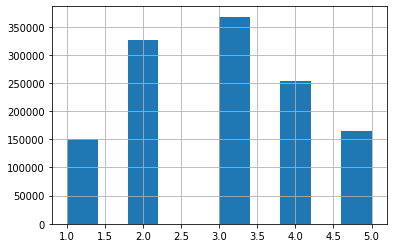

In [ ]:
#Distribution of number of tags
number_of_tags_for_post.hist()

In [ ]:
#Number of tags for post
tags_used = tags["Tag"].value_counts()
tags_used

javascript           124155
java                 115212
c#                   101186
php                   98808
android               90659
                      ...  
testcasesource            1
google-floodlight         1
iecapt                    1
netfs                     1
docker-windows            1
Name: Tag, Length: 37034, dtype: int64

In [ ]:
counter = 0
for i in tags_used:
  if i > 10:
    counter+=1
counter

14177

In [ ]:
#How many tags appear a certain number of times
print("#occurrences #tags")
occ_tags = tags_used.value_counts()
occ_tags

#occurrences #tags


1       6427
2       4148
3       2989
4       2245
5       1697
        ... 
1143       1
1139       1
1137       1
1136       1
671        1
Name: Tag, Length: 1193, dtype: int64

In [ ]:
#distribution of how many tags appear a certain number of times
tags_used_groups = tags_used.value_counts(bins=20)
tags_used_groups

(-123.155, 6208.7]      36973
(6208.7, 12416.4]          29
(12416.4, 18624.1]         11
(18624.1, 24831.8]          5
(24831.8, 31039.5]          3
(37247.2, 43454.9]          2
(43454.9, 49662.6]          2
(74493.4, 80701.1]          1
(111739.6, 117947.3]        1
(99324.2, 105531.9]         1
(93116.5, 99324.2]          1
(86908.8, 93116.5]          1
(62078.0, 68285.7]          1
(55870.3, 62078.0]          1
(31039.5, 37247.2]          1
(117947.3, 124155.0]        1
(80701.1, 86908.8]          0
(68285.7, 74493.4]          0
(49662.6, 55870.3]          0
(105531.9, 111739.6]        0
Name: Tag, dtype: int64

# Preprocessing

*As* shown in the next cell, the body of the questions have a lot of things that I have to elaborate in the preprocessing phase: HTML tags, punctuation, stop words, URLs and programming code. Right now I think I will remove HTML tags, punctuation and stop words. Programming code can be handled by CodeBERT, so I will leave it there. Still unsure what to do with URLs. 

In [5]:
import re
from bs4 import BeautifulSoup as soup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
q = questions["Body"].iloc[0]
q

'<p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile

In [7]:
def cleanpunc(sentence): 
    no_punct = sentence.translate(str.maketrans('', '', string.punctuation))
    return  no_punct

In [8]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", " ", phrase)
    return phrase

In [9]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def clean_stop_words(total_text):
    if type(total_text) is not int:
        string = ""
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        return string  

list of stop words: {"wouldn't", 'it', 'is', 'most', 'and', 'o', 't', 'not', 'through', 'i', 'when', 'only', 'some', 'its', 'whom', 'yourself', 'before', "haven't", 'your', 'yourselves', 'hers', 'into', 'himself', 'am', "you'd", 'them', 'does', 'now', 'hasn', 'for', 'herself', 'as', 'ain', 'there', 're', 'on', 'over', 'during', 'shan', 'doing', 'out', 'again', "doesn't", 'him', 'between', 'we', 'off', 'what', "you'll", "aren't", 'my', 'y', 'me', 'about', "needn't", "shan't", 'an', 'with', "isn't", 'theirs', 'from', "that'll", 'themselves', 'doesn', 've', 'own', "it's", 'her', 'll', 'those', 'can', 'you', 'below', 'at', "hadn't", 'being', 'in', 'why', 'the', 'then', 'too', 'm', 'd', 'myself', "mightn't", 'have', 'shouldn', 'or', 'very', 'so', 'should', "weren't", 'any', 'same', 'itself', 'was', 'been', 'won', 'ma', 'than', 'aren', "didn't", 'be', "should've", 'don', 'all', 'which', 'do', 'under', 'ourselves', 'didn', 'our', 'because', "couldn't", 'that', 'wouldn', 'up', 'while', 'mustn'

In [26]:
def preprocessing_operations(text):
  splitted_text_code = re.split('<pre><code>|</code></pre>', text)
  res = []
  for idx, text in enumerate(splitted_text_code):
    if idx%2 == 0:
      no_html = soup(text, "lxml").text
      no_punctuation = cleanpunc(no_html)
      no_contractions = decontracted(no_punctuation)
      no_stopwords = clean_stop_words(no_contractions)
      res.append(no_stopwords)
    else:
      res.append(text)
  return res

def preprocess_data(data):
  cleaned_text = []
  if type(data)==type("string"):
    cleaned_text = preprocessing_operations(data)
  else:
    body = data["Body"]
    for q in body:
      cleaned_text.append(preprocessing_operations(q))
  return cleaned_text

In [28]:
cleaned_data = preprocess_data(questions.iloc[0].Body)
cleaned_data

['Ive written database generation script SQL want execute Adobe AIR application ',
 'Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n',
 'I execute Adobe AIR using following methods ',
 'public static function RunSqlFromFile(fileName:String):void {\n    var file:File = File.applicationDirectory.resolvePath(fileName);\n    var stream:FileStream = new FileStream();\n    stream.open(file, FileMode.READ)\n    var strSql

# Embeddings

In [16]:
! pip install "transformers" "pytorch-lightning" 

     |████████████████████████████████| 3.5 MB 21.7 MB/s 
     |████████████████████████████████| 527 kB 41.3 MB/s 
     |████████████████████████████████| 895 kB 35.2 MB/s 
     |████████████████████████████████| 67 kB 3.6 MB/s 
     |████████████████████████████████| 6.8 MB 47.5 MB/s 
     |████████████████████████████████| 829 kB 46.9 MB/s 
     |████████████████████████████████| 133 kB 54.7 MB/s 
     |████████████████████████████████| 952 kB 40.3 MB/s 
     |████████████████████████████████| 397 kB 57.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=8776320064749e3ade39f098ba1742a015ee64eccdeae17f6bfb5572845f3dcc
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: 

In [17]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from __future__ import division
from math import ceil
import numpy as np

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
#does not work for multiple questions -> if any(isinstance(x, list) for x in my_list) or auxiliary function
tokens = [tokenizer.cls_token]
for l in cleaned_data: 
  code_tokens=tokenizer.tokenize(l)
  tokens += code_tokens
  tokens += [tokenizer.sep_token]
tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
print(len(tokens_ids))

536


The authors of CodeBert set the MAX_LENGTH for the sentences to 512(+2) so, if the input vector is too big, I can not compute the embeddings -> two possible solutions (https://github.com/microsoft/CodeBERT/issues/16):

*   use an RNN over k representations to obtain a final embedding;
*   take the average of the representations (https://towardsdatascience.com/how-to-do-average-and-max-word-embedding-for-long-sentences-f3531e99d998)

To use the cosine distance we need vectors that have same length ->there are two ways to obtain a representation for the texts of the same length:

*   use the [CLS] token;
*   use the average of the vectors




In [ ]:
try:  
  context_embeddings = model(torch.tensor(tokens_ids)[None,:])[0]
except:
  k = ceil(len(tokens_ids) / 512.0)
  chunks = np.array_split(tokens_ids, k)
  context_embeddings_list = model(torch.tensor(chunks[0])[None,:])[0]
  for i in range(1, len(chunks)):
    context_embeddings_list = torch.cat((context_embeddings_list, model(torch.tensor(chunks[i])[None,:])[0]), 1)
  #print(context_embeddings_list.shape)
  dim = context_embeddings_list.shape[-1]
  rnn = nn.RNN(dim, dim, 2) #number of hidden states = dimension of CodeBert's output, 2 layers
  output, hn = rnn(context_embeddings_list)

In [ ]:
output.shape

torch.Size([1, 536, 768])

In [ ]:
output

tensor([[[-0.1009,  0.3443,  0.0520,  ..., -0.0903,  0.1054, -0.0304],
         [-0.3266,  0.3464,  0.0668,  ...,  0.0048,  0.2402, -0.1957],
         [-0.2972,  0.4416, -0.0330,  ..., -0.0142,  0.2404, -0.0562],
         ...,
         [-0.2346,  0.4400, -0.0064,  ..., -0.0689,  0.2165, -0.0461],
         [-0.1530,  0.4739,  0.0492,  ..., -0.0366,  0.0913, -0.1430],
         [-0.1070,  0.3558,  0.0387,  ..., -0.0990,  0.1035, -0.0421]]],
       grad_fn=<StackBackward0>)

# Jina

In [12]:
!pip install jina
#! pip install docarray

     |████████████████████████████████| 864 kB 26.5 MB/s 
     |████████████████████████████████| 596 kB 36.3 MB/s 
     |████████████████████████████████| 52 kB 791 kB/s 
     |████████████████████████████████| 146 kB 55.2 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 1.8 MB 49.0 MB/s 
     |████████████████████████████████| 10.9 MB 56.3 MB/s 
     |████████████████████████████████| 111 kB 54.7 MB/s 
     |████████████████████████████████| 1.1 MB 46.1 MB/s 
     |████████████████████████████████| 3.6 MB 46.3 MB/s 
     |████████████████████████████████| 216 kB 49.0 MB/s 
     |████████████████████████████████| 3.8 MB 55.3 MB/s 
     |████████████████████████████████| 1.8 MB 46.5 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
     |████████████████████████████████| 402 kB 53.4 MB/s 
     |████████████████████████████████| 144 kB 64.9 MB/s 
     |███████████████

In [13]:
#import docarray import load_csv
from jina import Flow, Executor, requests, Document, DocumentArray, DocumentArrayMemmap

In [91]:
class MyTransformer(Executor):
    """Transformer executor class """

    def __init__(
            self,
            pretrained_model_name_or_path: str = "microsoft/codebert-base",
            device: str = 'cpu',
            *args,
            **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        self.model = AutoModel.from_pretrained(pretrained_model_name_or_path)

    def compute_embedding(self,tokens_ids):
      try:  
        context_embeddings = self.model(torch.tensor(tokens_ids)[None,:])[0]
      except:
        k = ceil(len(tokens_ids) / 512.0)
        chunks = np.array_split(tokens_ids, k)
        context_embeddings_list = self.model(torch.tensor(chunks[0])[None,:])[0]
        for i in range(1, len(chunks)):
          context_embeddings_list = torch.cat((context_embeddings_list, self.model(torch.tensor(chunks[i])[None,:])[0]), 1)
        dim = context_embeddings_list.shape[-1]
        rnn = nn.RNN(dim, dim, 2) #number of hidden states = dimension of CodeBert's output, 2 layers
        context_embeddings, hn = rnn(context_embeddings_list)
      #compute the average of the vectors
      avg_embeddings = torch.mean(context_embeddings,1)[0]
      return avg_embeddings

    @requests
    def encode(self, docs: 'DocumentArray', *args, **kwargs):
        tokens = [self.tokenizer.cls_token]
        texts = docs.get_attributes("text")
        for idx, q in enumerate(texts): 
          cleaned_q = preprocess_data(q)
          tokens = [self.tokenizer.cls_token]
          for l in cleaned_q:
            code_tokens = self.tokenizer.tokenize(l)
            tokens += code_tokens
            tokens += [self.tokenizer.sep_token]
          tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
          docs[idx].embedding = self.compute_embedding(tokens_ids)

In [92]:
docArray = DocumentArray([Document(id = questions.iloc[0].Id, text=questions.iloc[0].Body),
                          Document(id=questions.iloc[1].Id, text=questions.iloc[1].Body),
                          Document(id=questions.iloc[2].Id, text=questions.iloc[2].Body)])

e = MyTransformer()
e.encode(docArray)
docArray

<docarray.array.document.DocumentArray (length=3) at 140151451791120>

In [ ]:
# for d in docArray:
#   print("Document id: {}\nembedding: {} with size: {}".format(d.id, d.embedding, d.embedding.shape))

In [ ]:
docArray.plot_embeddings()

In [101]:
class MyIndexer(Executor):
    """Simple indexer class """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._docs = DocumentArrayMemmap() 

    @requests(on='/index')
    def index(self, docs: DocumentArray, **kwargs):
        self._docs.extend(docs)

    def print_matches(self, docs):
      for d in docs:
        print("Query: {}".format(d.text))
        for i, r in enumerate(d.matches):
          print("{}th result: {} with values: {}".format(i+1, d.id, r.scores['cosine'].value))

    @requests(on='/search')
    def search(self, docs: DocumentArray, **kwargs):
        """Append best matches to each document in docs"""
        print(self._docs)
        docs.match(self._docs, metric='cosine', normalization=(1, 0), limit=1, only_id=True) #device="cuda"
        self.print_matches(docs)

    def print_index(self):
      for d in self._docs:
        print("Document id: {}\nembedding: {} of shape: {}".format(d.id, d.embedding, d.embedding.shape))

In [ ]:
i = MyIndexer()
i.index(docArray) 
#i.print_index()
i.search(docArray)

In [ ]:
flow = (
        Flow(cors=True)
            .add(name='MyTransformer', uses=MyTransformer)
            .add(name='MyIndexer', uses=MyIndexer)
    )

In [ ]:
with flow, open("/content/drive/MyDrive/Data Mining/Project/Questions.csv", encoding="ISO-8859-1") as fp:
    docs = flow.index(DocumentArray.from_csv(fp, field_resolver={'Id': 'Body'}),show_progress=True)
    flow.encode(docs)
    flow.search("sql")
    #print(docs)